# Task

1. Download and prepare data
2. Read data:
    - Sort population and set new index  
    
3. Data selection:
    - data selection
    - join data frames to one  
    
4. Data analyiys:
    4.1. All data
       - hist
       - shapiro test
        
    4.2. Data standardization
        - polyfit
        
    4.3. Factors
    4.4. Europe data
    4.5. Anova

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import shapiro
import re

In [2]:
%cd ../data/

/home/u1/22_dydaktyka/04inzynier/data


In [3]:
%ls

countryPopulation.csv  WHO-COVID-19-global-data.csv
covid.csv              WPP2019_POP_F01_1_TOTAL_POPULATION_1.xlsx


In [4]:
cov = pd.read_csv('covid.csv',sep=';')
pop = pd.read_csv('countryPopulation.csv',sep=';')

In [5]:
cov.head(2)

,Date,Country,Ncases,CumCases,Ndeaths,Cumdeaths
0,2020-01-03,Afghanistan,0,0,0,0
1,2020-07-25,Afghanistan,55,36122,21,1250


In [6]:
pop.shape

(235, 5)

In [7]:
pop.head(2)

,Country,geo,zone,island,c2020
0,Afghanistan,Asia,south,no,38928341
1,Albania,Europe,south,no,2877800


In [8]:
idx = cov.Date == '2020-10-29'
tmp = cov.loc[idx]
tmp.head()

,Date,Country,Ncases,CumCases,Ndeaths,Cumdeaths
95,2020-10-29,Afghanistan,113,41145,6,1529
396,2020-10-29,Albania,311,20040,6,493
735,2020-10-29,Algeria,287,56706,9,1931
998,2020-10-29,American Samoa,0,0,0,0
1299,2020-10-29,Andorra,107,4517,0,72


In [9]:
data = tmp.merge(pop,on='Country')
idx = data.Country != 'other'
data = data.loc[idx]
print(data.shape)
data.head()

(229, 10)


,Date,Country,Ncases,CumCases,Ndeaths,Cumdeaths,geo,zone,island,c2020
0,2020-10-29,Afghanistan,113,41145,6,1529,Asia,south,no,38928341
1,2020-10-29,Albania,311,20040,6,493,Europe,south,no,2877800
2,2020-10-29,Algeria,287,56706,9,1931,Africa,north,no,43851043
3,2020-10-29,American Samoa,0,0,0,0,Oceania,other,yes,55197
4,2020-10-29,Andorra,107,4517,0,72,Europe,south,no,77265


# analysis

In [10]:
data.Cumdeaths.describe()

count       229.000000
mean       5109.157205
std       21481.201768
min           0.000000
25%          10.000000
50%         126.000000
75%        1153.000000
max      225073.000000
Name: Cumdeaths, dtype: float64

# gauss pdf

$$f = \frac{1}{\sigma \cdot \sqrt{2\pi}}\cdot e^{-0.5(\frac{x - \mu}{\sigma})^2}$$

In [11]:
def myPdf(data,n=100):
    '''Args:
        data:   pd.Series
        n:      int, number of bins'''
    data = data.copy()
    mu = data.mean()
    s = data.std()
    rng = (data.min(),data.max())
    x = np.random.uniform(*rng,n)
    x.sort()
    y = (1/(s*(2*np.pi)**0.5))*np.exp(-0.5*((x-mu)/s)**2)
    return x,y

In [12]:
x,y = myPdf(data.Cumdeaths)

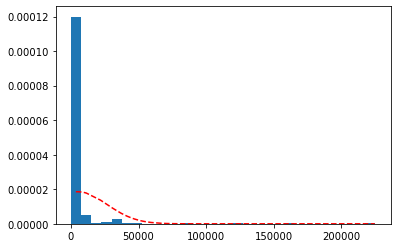

In [13]:
plt.hist(data.Cumdeaths,bins=30,density=True);
plt.plot(x,y,'--r')

### Normality test

In [14]:
from scipy.stats import shapiro

In [15]:
shapiro(data.Cumdeaths)

ShapiroResult(statistic=0.24027007818222046, pvalue=1.4183614895100863e-29)

In [16]:
print('stats: {:.3f}\tp-val: {:.9f}'.format(*shapiro(data.Cumdeaths)))

stats: 0.240	p-val: 0.000000000


### Bar plot

>- data sorting by 'Cumdeaths'
>- selection of countries for which 'Cumdeaths' is greater than 20
>- division of data into 4 parts 

In [17]:
data.sort_values('Cumdeaths',inplace=True)
tmp = data[data.Cumdeaths > 20]
tmp.shape

(168, 10)

In [18]:
# division of data into 4 parts
# division boundaries 'db'
db = np.round(np.linspace(0,tmp.shape[0],5),0).astype(int).tolist()
db

[0, 42, 84, 126, 168]

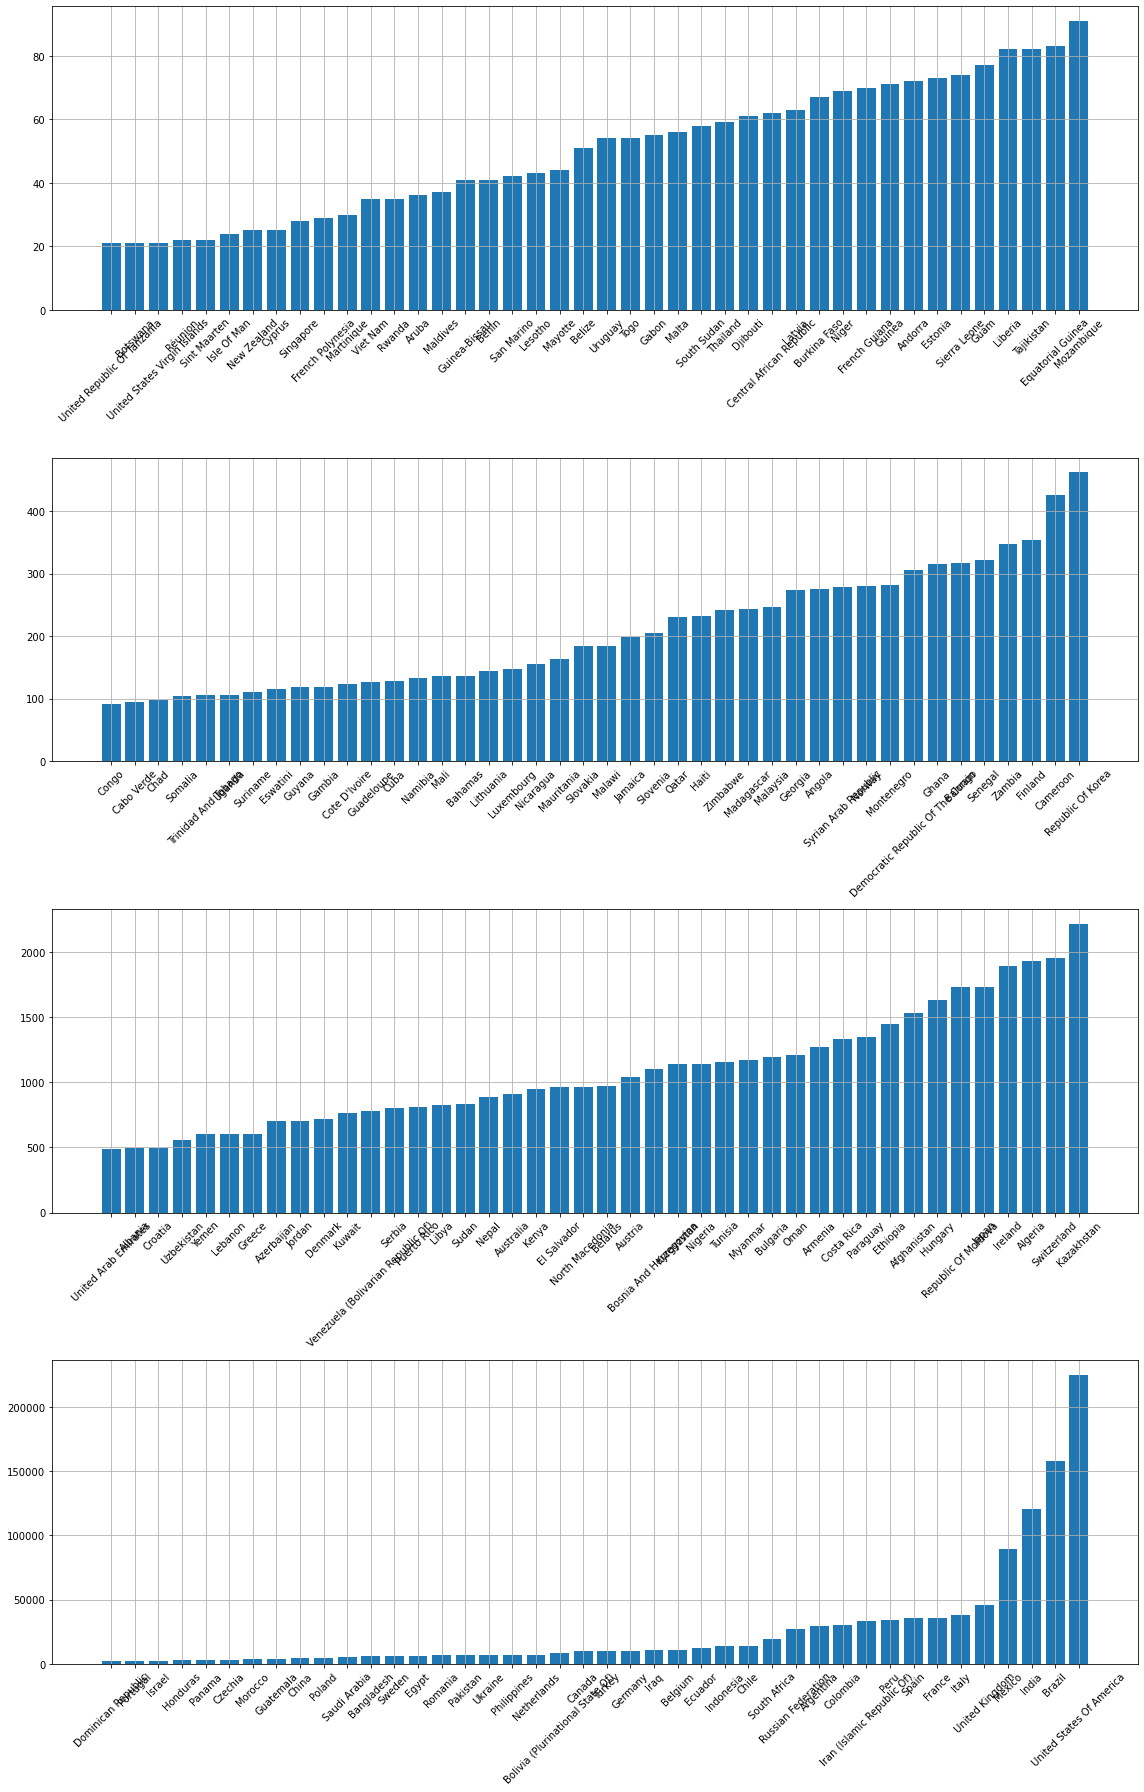

In [19]:
f= plt.figure(figsize=(16,25))

for i,v in enumerate(db[:-1]):
    tmp1 = tmp.iloc[db[i]:db[i+1]]

    plt.subplot(4,1,i+1)
    plt.bar(tmp1.Country,tmp1.Cumdeaths)
    plt.xticks(rotation=45)
    plt.grid()


plt.tight_layout()

### Simple regression

> linear model $y = ax+b$  
> checking the correlation between the population and the cumulative number of deaths

In [20]:
# np.polyfit(): Least squares polynomial fit
# returns: Polynomial coefficients,
cof = np.polyfit(data.c2020,data.Cumdeaths,1)
cof

array([6.74953633e-05, 2.82287320e+03])

In [21]:
# constructs a polynomial based on its coefficients
poly = np.poly1d(cof)
print(poly)

 
6.75e-05 x + 2823


In [22]:
# Calculate the y-values for the fitting line
yLine = poly(data.c2020)
yLine[:5]

array([3062.24058136, 2830.93525383, 3951.32622386, 2823.60444744,
       2842.14252143])

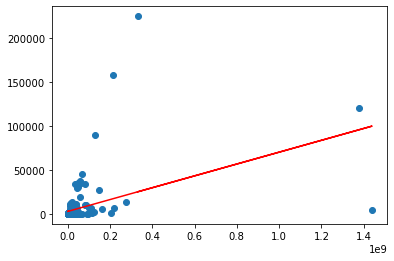

In [23]:
# plot scatter end firring line
plt.scatter(data.c2020,data.Cumdeaths)
plt.plot(data.c2020,yLine,'r')

### Correlation coefficient (Pearson)

In [24]:
np.corrcoef(data.c2020,data.Cumdeaths)

array([[1.        , 0.42991708],
       [0.42991708, 1.        ]])

### Standardization: number of deaths per million inhabitants

In [25]:
data.loc[:,'perMln'] = np.round((data.Cumdeaths/data.c2020)*10**6,1)
data = data.sort_values('perMln',ascending=False)
data.head()

,Date,Country,Ncases,CumCases,Ndeaths,Cumdeaths,geo,zone,island,c2020,perMln
215,2020-10-29,San Marino,20,903,0,42,Europe,south,no,33938,1237.6
195,2020-10-29,Peru,1923,892497,60,34257,America,south,no,32971845,1039.0
19,2020-10-29,Belgium,9,368243,20,11170,Europe,west,no,11589616,963.8
4,2020-10-29,Andorra,107,4517,0,72,Europe,south,no,77265,931.9
230,2020-10-29,Spain,9303,1136503,168,35466,Europe,south,no,46754783,758.6


In [26]:
tmp = data[data.perMln > 100]
print(f'Shape: {tmp.shape}')
tmp = tmp.sort_values('perMln')
tmp.head(3)

Shape: (81, 11)


,Date,Country,Ncases,CumCases,Ndeaths,Cumdeaths,geo,zone,island,c2020,perMln
18,2020-10-29,Belarus,936,95545,4,969,Europe,east,no,9449321,102.5
74,2020-10-29,French Polynesia,769,7262,3,29,Oceania,other,yes,280904,103.2
25,2020-10-29,"Bonaire, Sint Eustatius And Saba",3,153,0,3,America,middle,yes,26221,114.4


In [27]:
# division of data into 2 parts
# division boundaries 'db'
db = np.round(np.linspace(0,tmp.shape[0],3),0).astype(int).tolist()
db

[0, 40, 81]

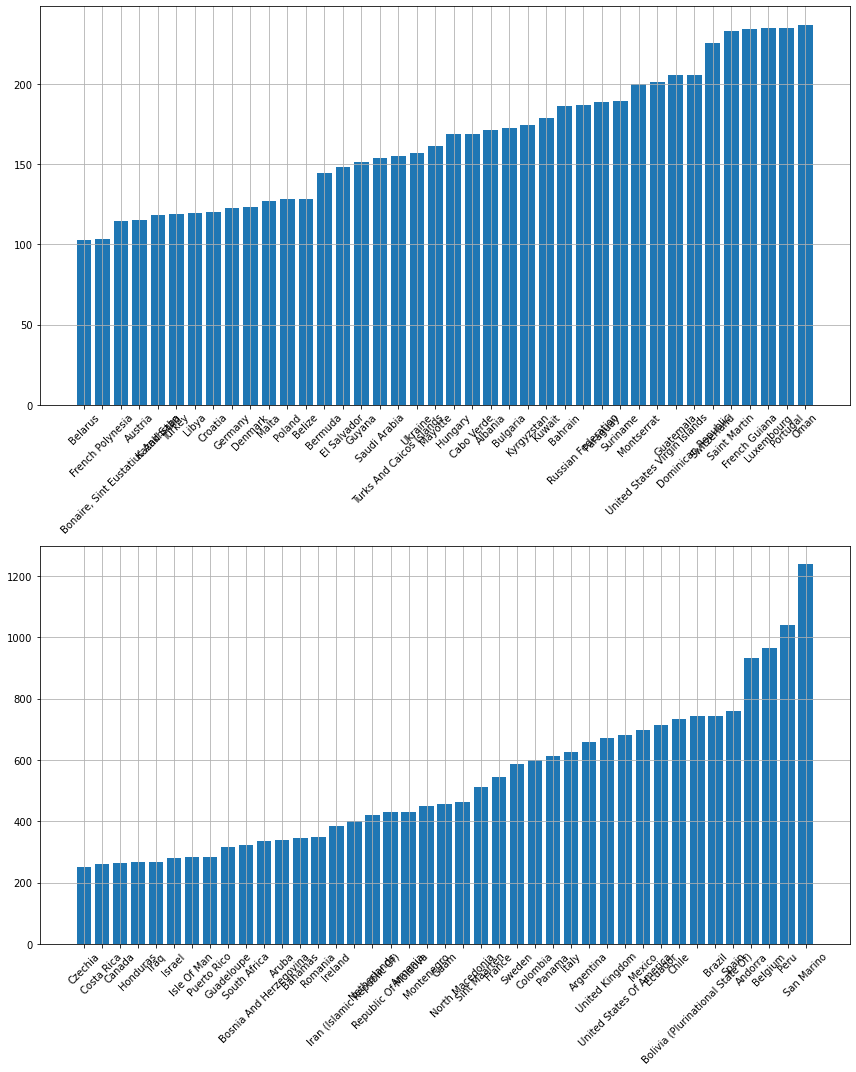

In [28]:
f= plt.figure(figsize=(12,15))

for i,v in enumerate(db[:-1]):
    tmp1 = tmp.iloc[db[i]:db[i+1]]

    plt.subplot(2,1,i+1)
    plt.bar(tmp1.Country,tmp1.perMln)
    plt.xticks(rotation=45)
    plt.grid()


plt.tight_layout()